<a href="https://colab.research.google.com/github/KartikChugh/MachineLearning/blob/master/kmeans_clustering_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Task: California Housing
> "Tonight, more than 130000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. **The biggest culprit is rising housing costs.** From 2000 to 2014, **median rent in California increased by more than one-third,** while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. **This crisis threatens not just low-income families but our entire economy,** driving businesses to relocate to states in which their employees can afford to live." 
\- _Business Insider, Sep 2018_



In this project, we implement the _k_-means clustering algorithm, and use it to analyze California housing data and draw insights with regards to the worsening housing crisis.

[_k_-means](https://en.wikipedia.org/wiki/K-means_clustering) is one of the most popular clustering algorithms, storing _k_ centroids that it uses to define clusters. An instance is considered to be in a particular cluster if it is closer to that cluster's centroid than any other. 

In [3]:
# Import common packages
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Setup graphical display
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Seed random number generation
SEED = 42
np.random.seed(SEED)

---
## 1. Data Preparation

The [California Housing dataset](https://www.kaggle.com/camnugent/california-housing-prices) is a popular choice in the machine learning field, initially featured in _Pace, R. Kelley, and Ronald Barry. "Sparse spatial autoregressions." Statistics & Probability Letters 33.3 (1997): 291-297._. As Scikit-Learn's documentation explains,

> This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

### Data Discovery & Visualization

We start by taking a look at the dataset, finding many different geographical and demographic variables to work with. For a regression task, _median_house_value_ might be our label i.e. we would estimate housing costs from other information. But **clustering, as an unsupervised learning task, has no labels**; instead, data points are grouped together based on common characteristics.

In [4]:
data = pd.read_csv('housing_ca.csv')

In [5]:
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


Next, we generate summary statistics for our numerical variables. Getting a sense of the center and range of each distribution will be important for interpreting our clusters later on. 

In [6]:
data.describe().round(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.0,20640.0,20640.0,20640.0,20433.0,20640.0,20640.0,20640.0,20640.0
mean,-119.6,35.6,28.6,2635.8,537.9,1425.5,499.5,3.9,206855.8
std,2.0,2.1,12.6,2181.6,421.4,1132.5,382.3,1.9,115395.6
min,-124.4,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1447.8,296.0,787.0,280.0,2.6,119600.0
50%,-118.5,34.3,29.0,2127.0,435.0,1166.0,409.0,3.5,179700.0
75%,-118.0,37.7,37.0,3148.0,647.0,1725.0,605.0,4.7,264725.0
max,-114.3,42.0,52.0,39320.0,6445.0,35682.0,6082.0,15.0,500001.0


We also obtain metadata for the dataset, revealing the counts and types for each variable. Notable is the "object" type for _ocean_proximity_, indicating a **categorical feature**, as well as the presence of **missing values** in _total_bedrooms_. Both of these characteristics will **inform our data preprocessing steps** when constructing our pipeline.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
num_features = data.select_dtypes(exclude=['object'])
cat_feature = data.select_dtypes(include=['object'])
num_feature_names = num_features.columns
cat_feature_name = cat_feature.columns

print('Numerical:', num_feature_names.to_numpy())
print('Categorical:', cat_feature_name.to_numpy())

Numerical: ['longitude' 'latitude' 'housing_median_age' 'total_rooms'
 'total_bedrooms' 'population' 'households' 'median_income'
 'median_house_value']
Categorical: ['ocean_proximity']


Histograms allow us to get a more visual insight into the summary statistics we reported above. There is clear right-skew to most features, which could be addressed through categorical slicing and stratified sampling. We forego these steps in this project for simplicity and ease of interpretability.

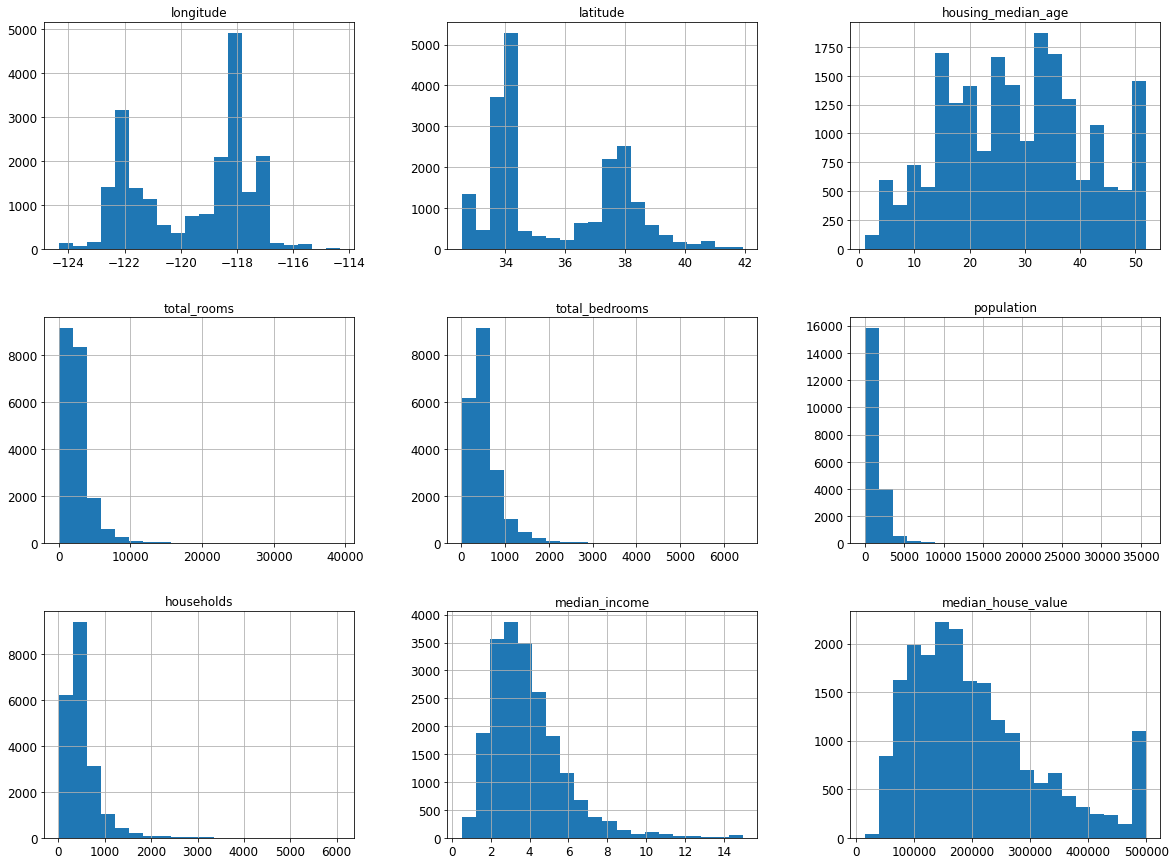

In [9]:
data.hist(bins=20, figsize=(20,15))
plt.show()

By design, **clustering collapses the dimensionality of data** by assigning datapoints into discrete buckets **based on similarity** (hence, "clusters"). This is obviously desirable when the purpose is to group data in this way, but gleaning the underlying patterns can be a little difficult. 

Below, we create a correlation matrix showing only scores above $|r|>0.6$  to understand colinear relationships among our features, such as: 
- the number of houses and rooms within a census block is strongly tied to its population count
- median incomes and home values are directly related
- latitude and longitude are negatively related

In [10]:
corr_matrix = data.corr().round(3)
corr_scores = pd.DataFrame(corr_matrix).applymap(lambda v: v if (abs(v) > 0.5 and v != 1) else '*')
corr_scores

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,*,-0.925,*,*,*,*,*,*,*
latitude,-0.925,*,*,*,*,*,*,*,*
housing_median_age,*,*,*,*,*,*,*,*,*
total_rooms,*,*,*,*,0.93,0.857,0.918,*,*
total_bedrooms,*,*,*,0.93,*,0.878,0.98,*,*
population,*,*,*,0.857,0.878,*,0.907,*,*
households,*,*,*,0.918,0.98,0.907,*,*,*
median_income,*,*,*,*,*,*,*,*,0.688
median_house_value,*,*,*,*,*,*,*,0.688,*


A "correlation" between latitude and longitude may seem a little arbitrary; investigating it with a scatter plot reveals a familiar shape: the state of California! 

We add a few visual characteristics to our plot, such as varying datapoint radius with population, and color intensity with home values. The resulting map hints at how our clusters might materialize if prices and population are heavily weighted.

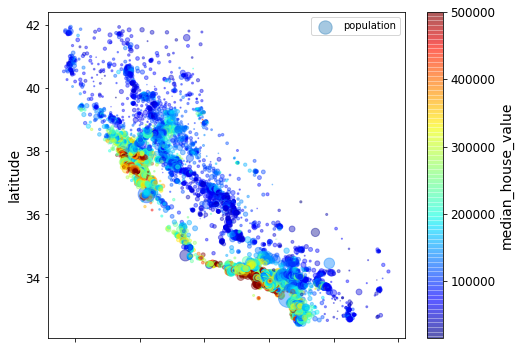

In [11]:
data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
    s=data['population']/100, label='population', figsize=(8,6),
    c='median_house_value', cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

### Data Preprocessing

As always, we build a pipeline to perform the necessary transformations to our dataset. Specifically, the following strategies:

1.   Impute missing numerical values with the variable's median value
2.   Standardize numerical features ($u=0$, $\sigma=1$)
3.   One-hot encode categorical features

And then the data is fed to the pipeline, assembled using Sklearn's `ColumnTransformer`.



In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

full_pipeline = ColumnTransformer(transformers=[
  ('num', num_pipeline, num_feature_names),
  ('cat', OneHotEncoder(), cat_feature_name)
])

In [13]:
# Create new categorical feature names for each class
cat_class_names = [_[0] for _ in cat_feature.value_counts().index]
cat_feature_names_prepared = [cat_feature_name.to_list()[0] + '_' + name for name in cat_class_names]

# Prepare new column names for processed data
column_names_prepared = np.concatenate((num_feature_names, cat_feature_names_prepared))

# Process and name data
data_prepared = pd.DataFrame(full_pipeline.fit_transform(data), columns=column_names_prepared)

Inspecting our new, **preprocessed dataset reveals** that _ocean_proximity_ was correctly split into **columns for each class**, and that **other features** were appropriately **scaled**.

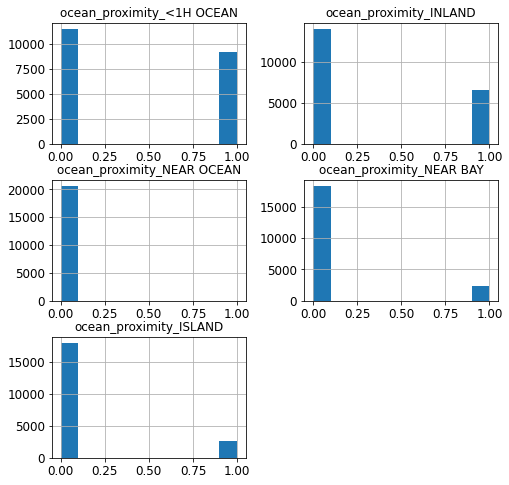

In [14]:
data_prepared[cat_feature_names_prepared].hist(figsize=(8,8))
plt.show()

In [15]:
data_prepared.describe().round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR OCEAN,ocean_proximity_NEAR BAY,ocean_proximity_ISLAND
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.44,0.32,0.00,0.11,0.13
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50,0.47,0.02,0.31,0.33
min,-2.39,-1.45,-2.20,-1.21,-1.28,-1.26,-1.30,-1.77,-1.66,0.00,0.00,0.00,0.00,0.00
25%,-1.11,-0.80,-0.85,-0.54,-0.57,-0.56,-0.57,-0.69,-0.76,0.00,0.00,0.00,0.00,0.00
50%,0.54,-0.64,0.03,-0.23,-0.24,-0.23,-0.24,-0.18,-0.24,0.00,0.00,0.00,0.00,0.00
75%,0.78,0.97,0.66,0.23,0.25,0.26,0.28,0.46,0.50,1.00,1.00,0.00,0.00,0.00
max,2.63,2.96,1.86,16.82,14.09,30.25,14.60,5.86,2.54,1.00,1.00,1.00,1.00,1.00


---
## 2. Model Implementation



### Distance Metrics

Using **distance functions**, our algorithm can **evaluate how distinct two datapoints are** from one another; low distance indicates similarity, while high distance says the opposite. 

We implement Manhattan, Euclidean, and Chebyshev distance metrics, which are generalized by the [Minkovski equation](https://en.wikipedia.org/wiki/Minkowski_distance),

$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ 

where $p=1$, $p=2$, and $p=\infty$ respectively.

In [16]:
def euc_dist(a, b):
  return np.sqrt(np.sum((a-b)**2))

def man_dist(a, b):
  return np.sum(abs(a-b))

def cheb_dist(a, b):
  return np.max(np.abs(a-b))

### _K_-Means Clustering

Next, we implement the **_k_-means algorithm** as follows.

Input a cluster count _k_ and _m_ datapoints each with its own vector of _n_ features, along with the choice of a distance measure. Then:

1. **Initialize _k_ centroids**. In our case, we use the [random partition method](https://en.wikipedia.org/wiki/K-means_clustering#Initialization_methods), where centroids are just the average of random clusters.
2. Assign each data point to the cluster that has the **closest centroid based on a distance measure** below.
3. After all data points have been assigned to clusters, **recalculate the centroids** for each cluster (as averages of all points in the cluster).
4. **Repeat** the data assignments and centroid calculations **until no change** in cluster assignment occurs between iterations.

In [17]:
# Returns an array of centroids corresponding to each cluster
def compute_centroids(clusters):
  return [np.mean(cluster, axis=0, keepdims=True) for cluster in clusters]

In [18]:
# Forms k clusters from provided instances, based on distance measure
def k_means(instances, k=3, dist=euc_dist, max_iters=300):
  centroids = compute_centroids(np.array_split(instances, k))
  clusters = None
  inertia = None
  
  for i in range(max_iters):
    clusters = [[] for centroid in centroids]
    inertia = 0

    for instance in instances:
      # Compute distance from each centroid
      dists = [dist(instance, centroid) for centroid in centroids]
      # Add instance to closest cluster
      ind = np.argmin(dists)
      clusters[ind].append(instance)
      # Increase inertia by squared distance to centroid
      inertia += dists[ind]**2 #

    centroids_new = compute_centroids(clusters)

    # Stop early if converged
    if (np.array_equal(centroids, centroids_new)):
      break

    centroids = centroids_new

  return {'centroids':centroids, 'clusters':clusters, 'inertia':inertia, 'iters':i+1}

---
## 3. Clustering Application

Now that we've implemented _k_-means, we can apply the algorithm for $k=2$ and $k=3$ clusters to test it out with a variety of distance metrics.




### Utility Functions

In [ ]:
# Computes within-cluster standard deviation
def compute_dev(cluster):
  return np.std(cluster, axis=0, keepdims=True)

In [ ]:
# Plots colored clusters and identifies centroids
def plot_clusters(clusters, centroids):
  x = 'longitude'
  y = 'latitude'

  plt.figure(figsize=(6, 6))
  plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.plasma(np.linspace(0,1,len(clusters)))))
  plt.xlabel(x)
  plt.ylabel(y)

  for cluster in clusters:
    cluster_df = pd.DataFrame(cluster, columns=column_names_prepared)
    plt.scatter(cluster_df[x], cluster_df[y], alpha=0.2)

  for centroid in centroids:
    centroid_df = pd.DataFrame(centroid, columns=column_names_prepared)
    plt.scatter(centroid_df[x], centroid_df[y], marker='s', color='black')

In [ ]:
# Generates plots for a range of k values and reports cluster information
def k_means_reports(k_range, dist=euc_dist, verbose=False):
  inertias = []
  for k in k_range:
    results = k_means(data_prepared.to_numpy(), k, dist)
    print('====================================================')
    print('CLUSTERING: k=' + str(k))
    print('Distance Metric:', dist.__name__)
    print('====================================================')

    print('Iterations:', results['iters'])
    print('Inertia (SSE):', round(results['inertia'], 2))

    plot_clusters(results['clusters'], results['centroids'])
    plt.show() 

    if verbose:
      print('Cluster Summaries:')
      for cluster, centroid in zip(results['clusters'], results['centroids']):
        print('\n----------------------------------------')
        print('Centroid')
        print(pd.DataFrame(centroid, columns=column_names_prepared).T)
        print()
        print('Within-Cluster Standard Deviation')
        print(pd.DataFrame(compute_dev(cluster), columns=column_names_prepared).T)

    inertias.append(results['inertia'])
  # Return inertia-per-k if using multiple k values
  if len(k_range) > 1:
    return inertias

### $k=2$

We form two clusters using Euclidean distance, and report each's centroids and standard deviations.

Note that the plot is a projection of a 14-dimensional dataset onto a 2D geographic plane; thus, centroids may _appear_ "close" and clusters uncontiguous, but this is rather illusory.

CLUSTERING: k=2
Distance Metric: euc_dist
Iterations: 23
Inertia (SSE): 155912.97


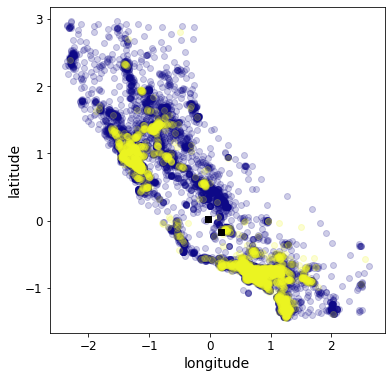

Cluster Summaries:

----------------------------------------
Centroid
                                   0
longitude                  -0.024322
latitude                    0.023025
housing_median_age          0.115296
total_rooms                -0.254142
total_bedrooms             -0.263935
population                 -0.244305
households                 -0.264263
median_income              -0.021161
median_house_value         -0.018543
ocean_proximity_<1H OCEAN   0.438158
ocean_proximity_INLAND      0.316228
ocean_proximity_NEAR OCEAN  0.000274
ocean_proximity_NEAR BAY    0.114748
ocean_proximity_ISLAND      0.130592

Within-Cluster Standard Deviation
                                   0
longitude                   0.999738
latitude                    1.007399
housing_median_age          0.972577
total_rooms                 0.462608
total_bedrooms              0.480907
population                  0.512918
households                  0.489685
median_income               1.005376
median_

In [ ]:
k_means_reports([2], euc_dist, verbose=True)

The two clusters have very close centroids when plotted on a 2D geographic plane, and their standard deviations for _longitude_ and _latitude_ are fairly large (~1.0). Together, these facts indicate that location scarely accounts for the clusters formed. 

Meanwhile, the clusters bear resemblance to the plot from our _Data Visualization_ step, in which pricier housing markets were emphasized with 'hotter' colors, suggesting that median home values play some role in our results.

However, our centroid and standard deviation data point towards the room, bedroom, household, and population count statistics as having the most significant differences. **A combination of the aforementioned factors is a likely explanation for our clusters** (e.g. high-population, expensive urban areas vs. rural). 

### $k=3$

Moving up to three clusters (Manhattan distance), we observe a stark difference compared to $k=2$. North California is largely put into its own cluster, with its centroid in the middle geographically, showing that location was weighted significantly for that cluster. 

CLUSTERING: k=3
Distance Metric: man_dist
Iterations: 31
Inertia (SSE): 892064.86


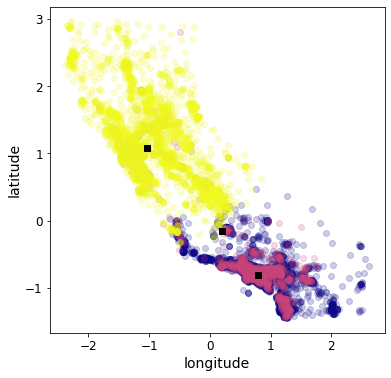

In [ ]:
k_means_reports([3], man_dist)

Geographic features' influence appears to be slightly diminished with Chebyshev distance, which values the features for which two datapoints differ the most. Still, the two graphs are very similar. Note that inertia values are not directly comparable for different distance metrics.

CLUSTERING: k=3
Distance Metric: cheb_dist
Iterations: 24
Inertia (SSE): 48880.02


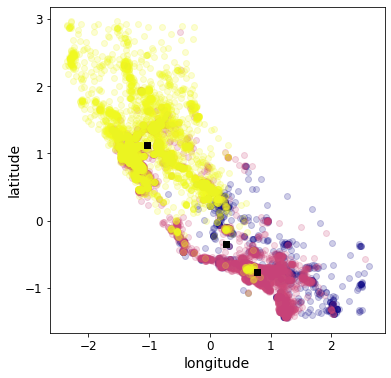

In [ ]:
k_means_reports([3], cheb_dist)

### $k = 4...10$

Let's see how the clusters evolve over a whole range of _k_ values!

CLUSTERING: k=4
Distance Metric: euc_dist
Iterations: 38
Inertia (SSE): 107067.75


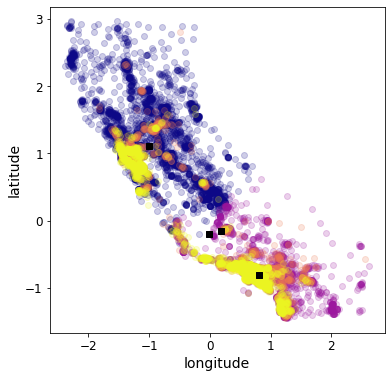

CLUSTERING: k=5
Distance Metric: euc_dist
Iterations: 48
Inertia (SSE): 94857.05


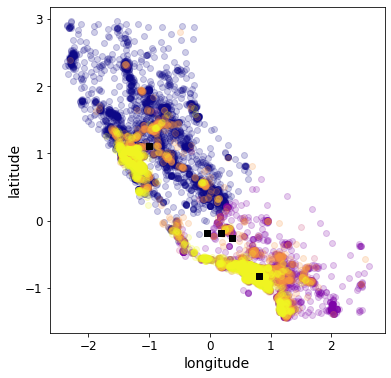

CLUSTERING: k=6
Distance Metric: euc_dist
Iterations: 72
Inertia (SSE): 87382.92


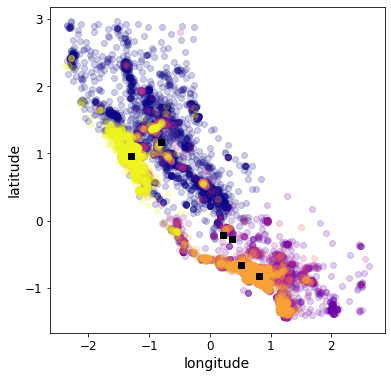

CLUSTERING: k=7
Distance Metric: euc_dist
Iterations: 58
Inertia (SSE): 82384.36


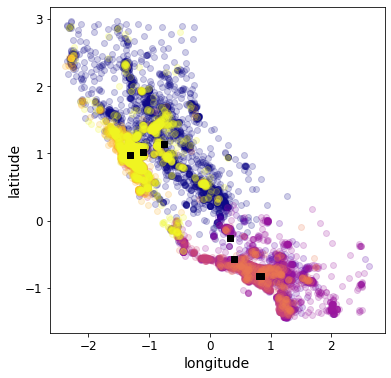

CLUSTERING: k=8
Distance Metric: euc_dist
Iterations: 47
Inertia (SSE): 78227.7


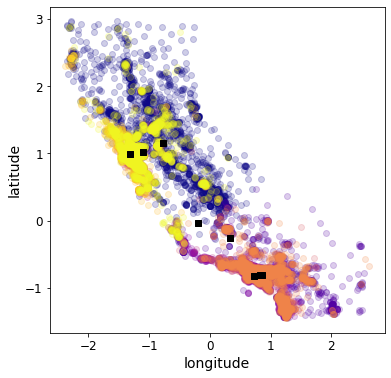

CLUSTERING: k=9
Distance Metric: euc_dist
Iterations: 60
Inertia (SSE): 73181.64


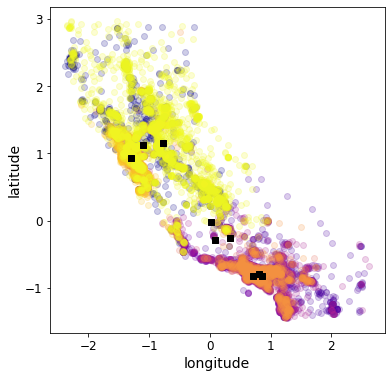

CLUSTERING: k=10
Distance Metric: euc_dist
Iterations: 83
Inertia (SSE): 69455.04


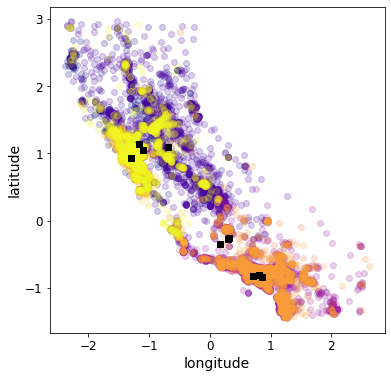

In [ ]:
k_range = range(4, 11)
inertias = k_means_reports(k_range)

As _k_ increases, the _k_-means clustering algorithm makes more and more geographical delineations within the originally larger clusters, back when we used $k=2$. Comparing the centroids with our _Data Visualization_ scatter plot, again, reveals **the effect of urbanization on housing markets, with higher populations, prices, and incomes**. Clear examples include the Bay Area and Silicon Valley. 

While dramatic changes occur as _k_ increases from 2 to 3 to 4, its impact appears to diminish beyond that. We can put some "elbow grease" into it, and verify this with the help of an elbow curve!

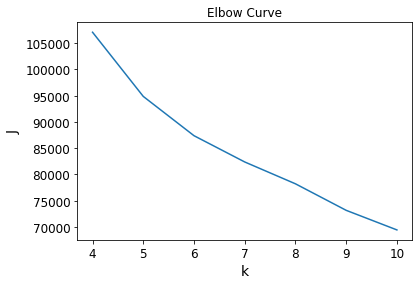

In [ ]:
plt.plot(k_range[1:], inertias[1:])
plt.xlabel('k')
plt.ylabel('J')
plt.title('Elbow Curve')
plt.show()

The popular ["elbow method"](https://en.wikipedia.org/wiki/Elbow_method_%28clustering%29) in cluster analysis says that, based on our curve, **~5 clusters is a balanced way to model our data**; more than that may just be overfitting.

---
## 4. Cluster Analysis

Finally, we select our optimal model and analyze the clusters' centroids & within-cluster standard deviations.

CLUSTERING: k=5
Distance Metric: euc_dist
Iterations: 48
Inertia (SSE): 94857.05


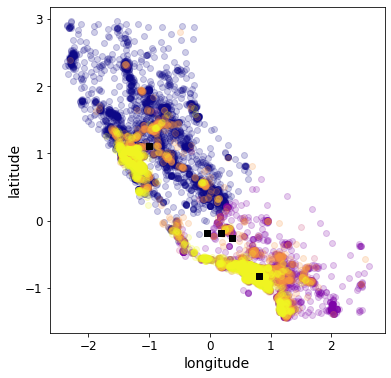

Cluster Summaries:

----------------------------------------
Centroid
                                   0
longitude                  -1.008261
latitude                    1.110853
housing_median_age          0.097733
total_rooms                -0.299254
total_bedrooms             -0.305604
population                 -0.335015
households                 -0.319959
median_income              -0.337208
median_house_value         -0.424883
ocean_proximity_<1H OCEAN   0.141607
ocean_proximity_INLAND      0.540178
ocean_proximity_NEAR OCEAN  0.000000
ocean_proximity_NEAR BAY    0.238588
ocean_proximity_ISLAND      0.079627

Within-Cluster Standard Deviation
                                   0
longitude                   0.512621
latitude                    0.494990
housing_median_age          1.033279
total_rooms                 0.438008
total_bedrooms              0.467050
population                  0.474986
households                  0.479873
median_income               0.637759
median_

In [ ]:
k_means_reports([5], euc_dist, verbose=True)

For each numerical feature, we can construct rough **intervals** defined by $[\mu - \sigma$, $\mu + \sigma]$ to capture a general approximation **of the values within each cluster** (we omit the categorical features due to different statistical properties and otherwise low signal). 

While centroids serve as simple point estimates, accounting for the variation within each cluster helps us ensure that we observe only _statistically significant_ differences between them. Note that the values were standardized during _Data Preprocessing_.



In [ ]:
# Computed off-site 
intervals= [
 ([-1.5, 0.4, -0.6, -0.8, -1.0], [-0.5, 1.2, 1.3, 1.1, 0.9]),
 ([0.6, -1.1, -1.2, -1.1, -1.0], [1.6, -0.5, 0.6, 0.7, 0.7]),
 ([-0.9, -0.7, -1.9, -1.5, -0.9], [1.1, 1.1, -0.7, -0.1, 1.2]),
 ([-0.7, -0.7, 2.9, 0.5, -0.6], [0.1, 0.1, 7.6, 2.1, 0.5]),
 ([-0.8, -0.7, 3.1, 0.6, -0.8], [0.2, 0.2, 7.1, 2.2, 0.2]),
 ([-0.8, -0.7, 2.2, 0.5, -0.8], [0.1, 0.3, 7.6, 2.1, 0.1]),
 ([-0.8, -0.7, 3.0, 0.7, -0.8], [0.2, 0.2, 7.1, 2.2, 0.2]),
 ([-1.0, -0.9, -0.5, -0.8, 0.4], [0.3, 0.3, 1.1, 0.8, 2.8]),
 ([-1.1, -0.9, -0.8, -0.8, 1.0], [0.3, 0.3, 0.9, 0.9, 2.5]),
]

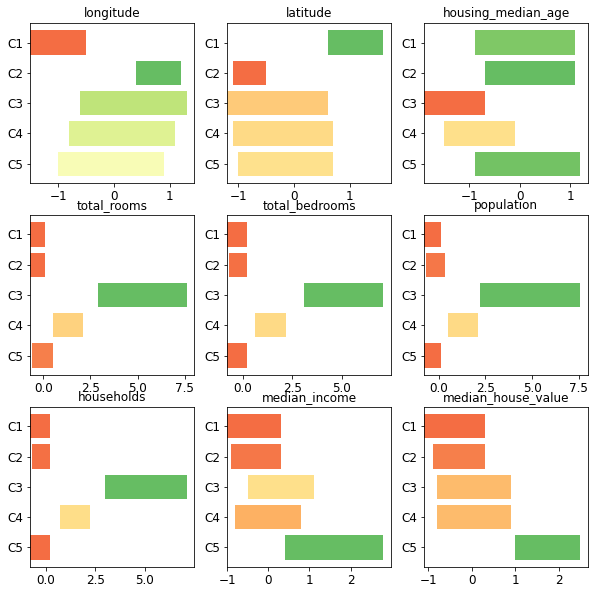

In [ ]:
plt.figure(figsize=(10, 10))
cluster_ind = ['C' + str(i) for i in range(1,6)]

for i, num_feature_name in enumerate(num_feature_names):
  
  bot, top = intervals[i]
  bot, top = np.array(bot), np.array(top)

  avg = np.mean((bot, top), axis=0)
  s  = np.interp(avg, (avg.min(), avg.max()), (0.2, 0.8))
  colors = plt.get_cmap('RdYlGn')(s)

  plt.subplot(3, 3, i+1)
  plt.barh(cluster_ind[::-1], (top-bot)[::-1], left=bot[::-1], color=colors[::-1])
  plt.title(num_feature_name)

Voilà! The intervals pierce through the noise of the raw data, helping shed some light on the clusters' compositions. Stacked and/or overlapped intervals represent commonalities between the clusters, while distanced intervals indicate uniquities. 

Focusing solely on the _longitude_ feature, we can see that Clusters 1 and 2 contain decidedly low and high values (respectively), while Clusters 3-5 have middling, indistinct values. Thus, we infer having **western longitudes to be characteristic of Cluster 1, and eastern longitudes to be characteristic of Cluster 2**; the remaining clusters are not defined meaningfully by their longitudes.

Note that the feature distributions must guide our analysis as well. The histograms created in _Data Visualization_ show, for example, show _population_ to be highly **right-skewed**; as such, we should expect some very distinct clusters (with respect to population) as a matter of course (i.e. **tighten our standards for significance**).





Using this system, we can interpret the clusters as follows:

* **Cluster 1:** northwest region
* **Cluster 2:** southeast region
* **Cluster 3:** new, large housing; populous districts
* **Cluster 5:** high-income, wealthy districts

with Cluster 4 encompassing generally average values for each feature (a "none of the above", so to speak). This raises the possibility that an additional cluster would help create a more meaningful delineation, but that is not guaranteed. 

Now, from all the information at our disposal, we can annotate the plot with fully identified clusters.

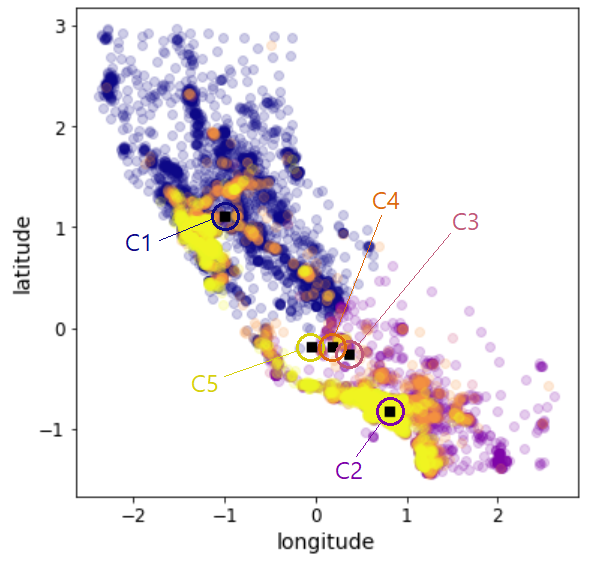

In [23]:
from IPython.display import Image
Image('clusters.png', width=400, height=400)

Many of our intuitions about the meaning of the clusters embed themselves in the plot. Clusters 1 and 2 are clearly geographically defined, while 5 unites two seemingly disparate regions due to common price levels; 3 is hard to differentiate but corresponds to some of the larger circles in _Data Visualization_. Cluster 4 picks up districts scattered all across the state, consistent with its role as a grab bag.

Overall, our clustering application and subsequent analysis points policymakers toward two key markets within which to tackle the housing crisis:

*   **Cluster 5** (yellow) would benefit from a housing boom focused on middle- to low-income homeowners to alleviate the upward pressure on prices. Supply-side initiatives may include easing restrictions on zoning and construction, while demand-side measures could consist of targeted subsidies to help move families into middle-income housing, thereby freeing up low-cost units for those who need them.
*   **Cluster 3** (pink) already has a fast-growing  housing stock, but if affordability remains an issue, officials may want to incentivize the construction of affordable housing units to serve the large populations.

